In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(project_root, 'RL-VLM-F'))

In [2]:
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from r3m import load_r3m
from reward_model import RewardModel
import torchvision.transforms as T
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
r3m = load_r3m("resnet50")
r3m.eval()
r3m.to(device)

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(128),
    T.ToTensor()
])

/home/sds685_ckk25/.conda/envs/projectvenv/lib/python3.9/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/sds685_ckk25/.conda/envs/projectvenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sds685_ckk25/.conda/envs/projectvenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# Random image test
img = np.random.randint(0, 255, (300, 300, 3), dtype=np.uint8)
pil_img = Image.fromarray(img)
tensor_img = transform(pil_img).unsqueeze(0).to(device) * 255.0

with torch.no_grad():
    embedding = r3m(tensor_img)

print(f"R3M embedding shape: {embedding.shape}")


R3M embedding shape: torch.Size([1, 2048])


/tmp/ipykernel_2732475/2567357171.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


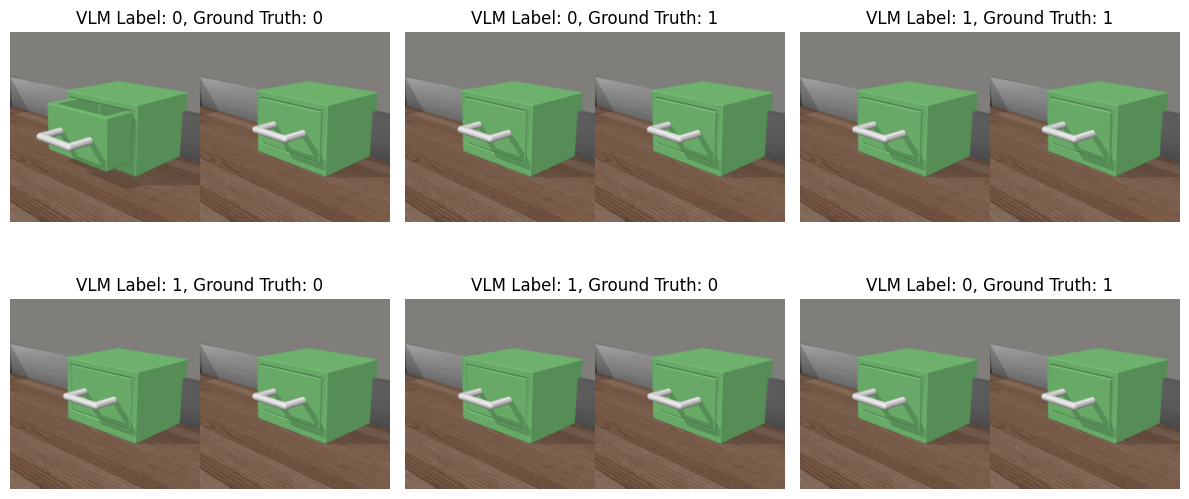

In [5]:

# Load the cached data
cached_dir = "../data/cached_labels/Drawer/seed_0"
files = sorted(os.listdir(cached_dir))
file_path = os.path.join(cached_dir, files[0])

with open(file_path, "rb") as f:
    data = pickle.load(f)

# Unpack
combined_images_list, rational_labels, vlm_labels, sa_t_1, sa_t_2, r_t_1, r_t_2 = data

# Sample 6 random examples
num_samples = 6
indices = np.random.choice(len(combined_images_list), size=num_samples, replace=False)

# Visualize
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs = axs.flatten()  

for i, idx in enumerate(indices):
    axs[i].imshow(combined_images_list[idx])
    axs[i].axis("off")
    axs[i].set_title(f"VLM Label: {vlm_labels[idx][0]}, Ground Truth: {rational_labels[idx][0]}")

plt.tight_layout()
plt.show()


In [6]:
import glob

# Load all pkl files across seed_0, seed_1, seed_2
base_dir = "../data/cached_labels/Drawer"
seed_dirs = sorted(glob.glob(os.path.join(base_dir, "seed_*")))

combined_images_list, rational_labels, vlm_labels = [], [], []
sa_t_1, sa_t_2, r_t_1, r_t_2 = [], [], [], []

for seed_dir in seed_dirs:
    files = sorted(os.listdir(seed_dir))
    for fname in files:
        with open(os.path.join(seed_dir, fname), "rb") as f:
            data = pickle.load(f)
            combined_images_list.append(data[0])
            rational_labels.append(data[1])
            vlm_labels.append(data[2])
            sa_t_1.append(data[3])
            sa_t_2.append(data[4])
            r_t_1.append(data[5])
            r_t_2.append(data[6])

# Concatenate all loaded data
combined_images_list = np.concatenate(combined_images_list, axis=0)
rational_labels = np.concatenate(rational_labels, axis=0)
vlm_labels = np.concatenate(vlm_labels, axis=0)
sa_t_1 = np.concatenate(sa_t_1, axis=0)
sa_t_2 = np.concatenate(sa_t_2, axis=0)
r_t_1 = np.concatenate(r_t_1, axis=0)
r_t_2 = np.concatenate(r_t_2, axis=0)

print("Total examples across all seeds:", len(combined_images_list))

/tmp/ipykernel_2732475/2966345590.py:14: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


Total examples across all seeds: 5596


In [7]:
left_imgs = [img[:, :img.shape[1] // 2] for img in combined_images_list]
right_imgs = [img[:, img.shape[1] // 2:] for img in combined_images_list]

In [8]:
def preprocess_images(images):
    batch = []
    for img in images:
        pil = Image.fromarray(img.astype(np.uint8))
        tensor = transform(pil)  
        batch.append(tensor)
    batch = torch.stack(batch).to(device) * 255.0  # [0, 255]
    return batch

In [9]:
def embed_images(images, batch_size=64):
    all_embeddings = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        batch_tensor = preprocess_images(batch)
        with torch.no_grad():
            emb = r3m(batch_tensor).cpu().numpy()
        all_embeddings.append(emb)
    return np.concatenate(all_embeddings, axis=0)

# Embed left and right halves
left_embed = embed_images(left_imgs)
right_embed = embed_images(right_imgs)

print("Left Embedding:", left_embed.shape)
print("Right Embedding:", right_embed.shape)


Left Embedding: (5596, 2048)
Right Embedding: (5596, 2048)



LABEL DISTRIBUTION:
Label 0: 501 samples
Label 1: 3975 samples

🏋️ Training on raw VLM labels buffer...
Epoch 001 |  Train Acc (raw VLM): 0.7413
Epoch 002 |  Train Acc (raw VLM): 0.8823
Epoch 003 |  Train Acc (raw VLM): 0.9106
Epoch 004 |  Train Acc (raw VLM): 0.9319
Epoch 005 |  Train Acc (raw VLM): 0.9388
Epoch 006 |  Train Acc (raw VLM): 0.9419
Epoch 007 |  Train Acc (raw VLM): 0.9421
Epoch 008 |  Train Acc (raw VLM): 0.9417
Epoch 009 |  Train Acc (raw VLM): 0.9408
Epoch 010 |  Train Acc (raw VLM): 0.9433
Epoch 011 |  Train Acc (raw VLM): 0.9450
Epoch 012 |  Train Acc (raw VLM): 0.9435
Epoch 013 |  Train Acc (raw VLM): 0.9471
Epoch 014 |  Train Acc (raw VLM): 0.9464
Epoch 015 |  Train Acc (raw VLM): 0.9430
Epoch 016 |  Train Acc (raw VLM): 0.9446
Epoch 017 |  Train Acc (raw VLM): 0.9468
Epoch 018 |  Train Acc (raw VLM): 0.9475
Epoch 019 |  Train Acc (raw VLM): 0.9453
Epoch 020 |  Train Acc (raw VLM): 0.9479
Epoch 021 |  Train Acc (raw VLM): 0.9475
Epoch 022 |  Train Acc (raw VLM): 

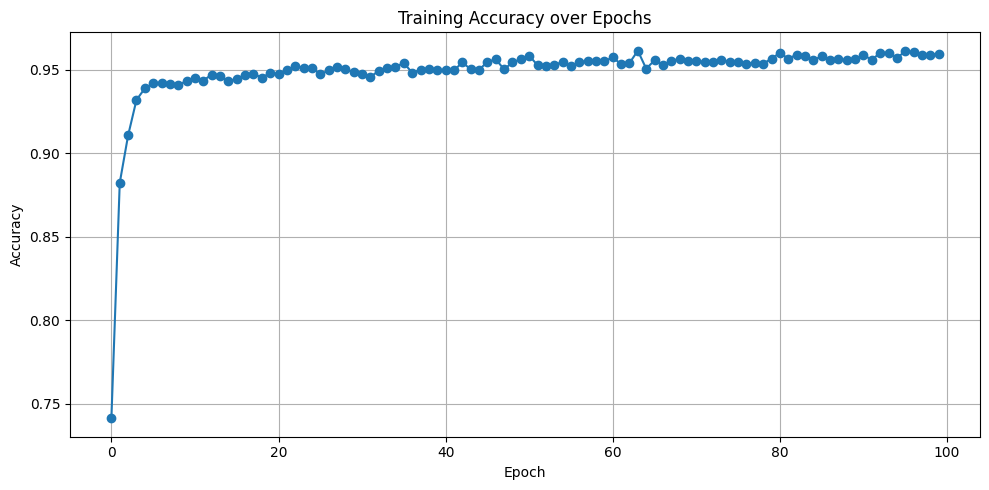

In [107]:

X1 = left_embed.astype(np.float32)
X2 = right_embed.astype(np.float32)
y = vlm_labels.flatten().astype(np.int64)  # ← USE RAW VLM LABELS DIRECTLY

X = X1 - X2

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(X)), test_size=0.2, random_state=42
)
X_buf = X_train[:, np.newaxis, :]
y_buf = y_train.reshape(-1, 1).astype(np.int64)

print("\nLABEL DISTRIBUTION:")
train_counts = Counter(y_buf.flatten())
for label, count in sorted(train_counts.items()):
    print(f"Label {label}: {count} samples")

# === 4. Initialize Model ===
model = RewardModel(
    ds=X.shape[1],
    da=0,
    image_reward=False,
    vlm_label=False,
    cached_label_path="",
    ensemble_size=1,
    size_segment=1,
    activation='relu',
    lr=1e-3,
    mb_size=64,
    large_batch=128,
    label_margin=0.0,
    teacher_beta=1.0,
    teacher_gamma=1.0,
    teacher_eps_mistake=0.0,
    teacher_eps_skip=0.0,
    teacher_eps_equal=0.0,
    capacity=len(X_buf) + 1,
    reward_model_layers=2,
    reward_model_H=128
)

model.put_queries(X_buf, np.zeros_like(X_buf), y_buf)

# === 5. Train on Buffer Only ===
print("\n🏋️ Training on raw VLM labels buffer...")
train_accuracies = []  # For plotting

for epoch in range(100):
    acc = model.train_reward()
    train_acc = np.mean(acc)
    train_accuracies.append(train_acc)  # Record accuracy
    print(f"Epoch {epoch+1:03d} |  Train Acc (raw VLM): {train_acc:.4f}")
    if train_acc >= 0.98:
        print(f" Early stopping at epoch {epoch+1}")
        break

# === 6. Save ===
save_dir = "./trained_reward_model_final"
os.makedirs(save_dir, exist_ok=True)
model.save(save_dir, step=0)
print("\n Training complete and model saved.")

# === 7. Plot Training Accuracy ===
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, marker='o')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "training_accuracy.png"))  # Save figure
plt.show()


In [102]:
#Evaluate on Test Set#
print("\n Evaluating on test set using train_reward logic...")

X_test_buf = X_test[:, np.newaxis, :]
y_test_buf = y_test.reshape(-1, 1).astype(np.int64)

model.buffer_index = 0
model.buffer_full = False
model.put_queries(X_test_buf, np.zeros_like(X_test_buf), y_test_buf)

model.eval()
test_acc = np.mean(model.train_reward())

print(f"\n🎯 FINAL TEST ACCURACY (raw VLM, train_reward method): {test_acc:.4f}")



🧪 Evaluating on test set using train_reward logic...

🎯 FINAL TEST ACCURACY (raw VLM, train_reward method): 0.9446


In [104]:
print("\n🧠 Evaluating on test set using rational labels and train_reward logic...")

# Create input buffer
X_rational_test_buf = X_test[:, np.newaxis, :]
y_rational_test_buf = rational_labels[idx_test].reshape(-1, 1).astype(np.int64)

# Clear and reload model buffer with rational labels
model.buffer_index = 0
model.buffer_full = False
model.put_queries(X_rational_test_buf, np.zeros_like(X_rational_test_buf), y_rational_test_buf)

# Evaluate using train_reward
model.eval()
rational_test_acc = np.mean(model.train_reward())

print(f"\n🎯 FINAL TEST ACCURACY (rational labels, train_reward method): {rational_test_acc:.4f}")



🧠 Evaluating on test set using rational labels and train_reward logic...

🎯 FINAL TEST ACCURACY (rational labels, train_reward method): 0.5768


In [76]:
from collections import Counter

label_counts = Counter(y_test)
total = len(y_test)
print("\n🧮 Test Label Distribution:")
for label, count in sorted(label_counts.items()):
    print(f"Label {label}: {count} samples ({100 * count / total:.2f}%)")



🧮 Test Label Distribution:
Label 0: 135 samples (12.05%)
Label 1: 985 samples (87.95%)
